In [1]:
from __future__ import division
import numpy as np
import pylab as plt
import scipy.optimize as op
from scipy.integrate import odeint
from scipy.integrate import nquad
%matplotlib inline

In [2]:
#length in cm, Density in GeV/cm^3

#Milky Way
"""
r_s = 20 * 3.08567758e19 # cm
rho_0 = 0.4 # GeV/cm^3
a = 0.2

def DM_density_NFW(rho_0, r_s, r):
    print(rho_0 / ((r / r_s) * (1 + (r / r_s))**2 ))
    
def DM_density_BURK(rho_0, r_s, r):
    print(rho_0 / ((1 + r / r_s) * (1 + (r / r_s )**2)))
    
def DM_denisty_EIN(rho_0, r_s, a, r):
    print(rho_0 * exp(-(2 / a) * ((r/r_s)**a - 1)))
"""

'\nr_s = 20 * 3.08567758e19 # cm\nrho_0 = 0.4 # GeV/cm^3\na = 0.2\n\ndef DM_density_NFW(rho_0, r_s, r):\n    print(rho_0 / ((r / r_s) * (1 + (r / r_s))**2 ))\n    \ndef DM_density_BURK(rho_0, r_s, r):\n    print(rho_0 / ((1 + r / r_s) * (1 + (r / r_s )**2)))\n    \ndef DM_denisty_EIN(rho_0, r_s, a, r):\n    print(rho_0 * exp(-(2 / a) * ((r/r_s)**a - 1)))\n'

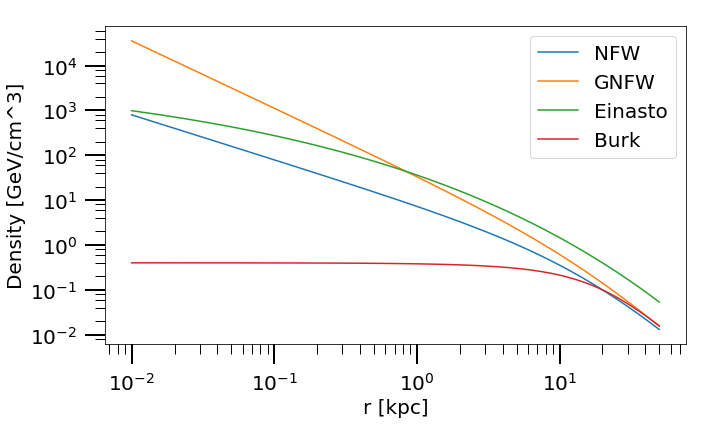

In [3]:
# Distance in cm
# Density in GeV/cm^3
# kpc in cm 3,086e+21
kpc_to_cm=3.086e+21

def DM_density_NFW(r, rho_0, r_s):
    return rho_0 / ((r / r_s) * (1 + (r / r_s))**2 )
    
def DM_density_BURK(r, rho_0, r_s):
    return rho_0 / ((1 + r / r_s) * (1 + (r / r_s )**2))
    
def DM_denisty_EIN(r, rho_0, r_s, a):
    return rho_0 * np.exp(-(2 / a) * ((r/r_s)**a - 1))

def DM_density_GNFW(r, rho_0, r_s, gamma):
    return rho_0/((r/r_s)**gamma*(1+(r/r_s))**(3-gamma))

r=np.logspace(np.log10(0.01*kpc_to_cm), np.log10(50*kpc_to_cm))

density_NFW=DM_density_NFW(r, rho_0=0.4, r_s=20*kpc_to_cm)
density_GNFW=DM_density_GNFW(r, rho_0=0.4, r_s=20*kpc_to_cm, gamma=1.5)
density_EIN=DM_denisty_EIN(r, rho_0=0.4, r_s=20*kpc_to_cm, a=0.2)
density_BURK=DM_density_BURK(r, rho_0=0.4, r_s=20*kpc_to_cm)




fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(r/kpc_to_cm, density_NFW, label="NFW")
ax.plot(r/kpc_to_cm, density_GNFW, label="GNFW")
ax.plot(r/kpc_to_cm, density_EIN, label="Einasto")
ax.plot(r/kpc_to_cm, density_BURK, label="Burk")

ax.set_xlabel("r [kpc]", fontsize=20)
ax.set_ylabel("Density [GeV/cm^3]", fontsize=20)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_title("Compton scattered spectrum $E_{photon,in}=$"+str(e_in))
ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
#Milkey Way

def DM_density_NFW(l,mu):
    rho_0 = 0.471 # GeV/cm^3
    r_s = 16 * kpc_to_cm #cm
    d = 8.5 * kpc_to_cm
    r = (l**2 + d**2 - 2*l*d*mu)**0.5
    return 2*np.pi*(rho_0 / ((r / r_s) * (1 + (r / r_s))**2))**2


d = 8.5 * kpc_to_cm
#thetha = (np.pi / 180 ) * 0.5 #radian

angle = np.linspace(0.5,30,50)
J_factor = []

for i in angle:
    thetha = (np.pi / 180 ) * i #radian
    result1 = nquad(DM_density_NFW, [[0,2*d],[np.cos(thetha),1]])
    J_factor.append(result1[0])

    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(angle, J_factor, label="NFW")
ax.set_xlabel("Angle [Degree]", fontsize=20)
ax.set_ylabel(r"J-Factor [$GeV^2/cm^5$]", fontsize=20)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0,30])
#ax.set_title("Compton scattered spectrum $E_{photon,in}=$"+str(e_in))
ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)

plt.tight_layout()
plt.show()
    

print("J-factor:", result1[0], "GeV^2/cm^5")

C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:356: IntegrationWarning: The algorithm does not converge.  Roundoff error i

ZeroDivisionError: float division by zero

In [ ]:
def DM_density_NFW(l,mu):
    rho_0 = 0.4 # GeV/cm^3
    r_s = 20 * kpc_to_cm #cm
    d = 105 * kpc_to_cm
    r = (l**2 + d**2 - 2*l*d*mu)**0.5
    return (rho_0 / ((r / r_s) * (1 + (r / r_s))**2))**2


d = 50 * kpc_to_cm
result1 = nquad(DM_density_NFW, [[0,d],[-1,1]])
print("J-factor:", result1[0], "GeV^2/cm^5")


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(r/kpc_to_cm, density_NFW, label="NFW")

